In [1]:
ls

5_tensorflow_traffic_light_images/  model.txt
checkpoint                          preview/
model.ckpt.data-00000-of-00001      test_images/
model.ckpt.index                    traffic_light.ipynb
model.ckpt.meta                     traffic_light_ranking.ipynb


In [2]:
%matplotlib inline

import sys, os, time
import itertools
import math, random
import tensorflow as tf
from functools import partial
from tensorflow import keras
from tensorflow.keras import utils, layers
from tensorflow.keras.layers import Dropout
from tensorflow.contrib.layers import flatten

import numpy as np
import cv2
import glob
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings

warnings.filterwarnings('ignore')

In [3]:
#Basic Parameters
max_epochs = 40
base_image_path = "5_tensorflow_traffic_light_images"
image_types= ["red", "green", "yellow"]
input_img_x = 32
input_img_y = 32
train_test_split_ratio = 0.9
batch_size = 32
learning_rate = 0.001
batch_prob = tf.placeholder(tf.bool)
checkpoint_name = "model.ckpt"

In [4]:
v_loss = least_loss = 99999999

In [5]:
#Load data
full_set = []

for im_type in image_types:
    print('im_type:', im_type)
    for ex in glob.glob(os.path.join(base_image_path,im_type, "*")):
        print(ex)
        im = cv2.imread(ex)
        if not im is None:
            #resizing
            im = im / 255
            im = cv2.resize(im, (32, 32))
            im = im.astype(np.float32)
            im += tf.keras.preprocessing.image.random_rotation(im, 30, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest', interpolation_order=1)
        
            #create an anrray representing our classes and set it
            one_hot_array = [0] * len(image_types)
            one_hot_array[image_types.index(im_type)] = 1

            assert(im.shape == (32, 32, 3))

            full_set.append((im, one_hot_array, ex))

random.shuffle(full_set)

im_type: red
5_tensorflow_traffic_light_images/red/0023f366-a173-4ba7-952c-63f5698c022d.jpg
5_tensorflow_traffic_light_images/red/00601e2b-af06-4b91-a50b-d94385371b01.jpg
5_tensorflow_traffic_light_images/red/0166f90e-c685-4f0b-98ed-0c3fd338ff01.jpg
5_tensorflow_traffic_light_images/red/01d76b8c-dc66-47b6-83d4-b00826dfec18.jpg
5_tensorflow_traffic_light_images/red/022ae068-6f6e-4563-97c1-f96261b436e6.jpg
5_tensorflow_traffic_light_images/red/0230d0a6-0eac-4bf1-bc0c-560f18ad7415.jpg
5_tensorflow_traffic_light_images/red/025e999e-e9c9-49a6-b9a5-4ced52b73c64.jpg
5_tensorflow_traffic_light_images/red/026e3566-6f8a-41be-9f41-dd877d8dce46.jpg
5_tensorflow_traffic_light_images/red/02ebf5b7-739f-4a80-a719-e0c465a5d390.jpg
5_tensorflow_traffic_light_images/red/02ed0cac-f1e9-4ed2-a04a-60abe027740f.jpg
5_tensorflow_traffic_light_images/red/0313fdea-c8b1-458b-adac-adcb4aac3622.jpg
5_tensorflow_traffic_light_images/red/031d48c3-c91e-44c5-a41c-5da047b6536d.jpg
5_tensorflow_traffic_light_images/red/0

5_tensorflow_traffic_light_images/red/20410986-8e88-4e02-8d95-b31e12b7f7a3.jpg
5_tensorflow_traffic_light_images/red/209d813f-8aac-43d1-8026-7197933e5259.jpg
5_tensorflow_traffic_light_images/red/20c45f94-8f7d-421b-80db-8d78aa7372b3.jpg
5_tensorflow_traffic_light_images/red/20c6a89d-ad35-4f3f-bc02-0151adc8861d.jpg
5_tensorflow_traffic_light_images/red/214c3c08-02e1-4088-990e-df4f3de35481.jpg
5_tensorflow_traffic_light_images/red/21569b8b-8879-4c75-b620-2e348c01ec98.jpg
5_tensorflow_traffic_light_images/red/21a5299c-611e-4ff6-b180-12ccf688e366.jpg
5_tensorflow_traffic_light_images/red/22bc876f-053d-4f3e-9a1e-eaa029b7261b.jpg
5_tensorflow_traffic_light_images/red/22c764bc-54b9-4547-8aaf-26b082d54fc5.jpg
5_tensorflow_traffic_light_images/red/22d53cca-a77f-4ea3-ba85-f5e1ec63c295.jpg
5_tensorflow_traffic_light_images/red/22e2c597-931c-46a1-b05c-2a1c264c6d70.jpg
5_tensorflow_traffic_light_images/red/22e9010f-d0fb-4569-a87f-b3ec411df57f.jpg
5_tensorflow_traffic_light_images/red/22ea212e-5705-

5_tensorflow_traffic_light_images/red/3e24eebb-9e3b-4904-be4b-e1a6fc37c32d.jpg
5_tensorflow_traffic_light_images/red/3e4a3e56-dbca-4080-9eb6-64a53a39720d.jpg
5_tensorflow_traffic_light_images/red/3e801d7b-b2e8-4ad7-876c-3dd4a64f1574.jpg
5_tensorflow_traffic_light_images/red/3e817dae-e718-49d2-b9b4-7c78497d0975.jpg
5_tensorflow_traffic_light_images/red/3ea8de5a-073b-4670-9009-6e32ac466c32.jpg
5_tensorflow_traffic_light_images/red/3f3db0c1-b953-4a13-a76b-735e20401b11.jpg
5_tensorflow_traffic_light_images/red/3f609861-dff1-4efa-a2b4-e8b2621eb936.jpg
5_tensorflow_traffic_light_images/red/3f9ddc8e-cc11-4ac3-920e-8c7ada784301.jpg
5_tensorflow_traffic_light_images/red/3fc15cf3-4b5b-4105-86b7-a76b5889bf2a.jpg
5_tensorflow_traffic_light_images/red/403ec9ee-4173-4022-b001-a56ae6181ca8.jpg
5_tensorflow_traffic_light_images/red/408bc30b-7c15-45d6-a600-3d3ee1823688.jpg
5_tensorflow_traffic_light_images/red/41655e11-82f1-4c17-b73d-ac3a25ca0df1.jpg
5_tensorflow_traffic_light_images/red/41a857d7-b623-

5_tensorflow_traffic_light_images/red/64992656-6f10-4592-8f02-2ea3452cc319.jpg
5_tensorflow_traffic_light_images/red/6533f619-a0bb-4038-a246-3994bb3e8645.jpg
5_tensorflow_traffic_light_images/red/65698c10-ce73-4df9-ac78-af3ea1732772.jpg
5_tensorflow_traffic_light_images/red/65946d06-198e-4be4-86f3-5402b3a7941e.jpg
5_tensorflow_traffic_light_images/red/65a25f19-8b99-4c07-99af-4359c32a19bf.jpg
5_tensorflow_traffic_light_images/red/65be73ba-ca16-4aee-bd0a-0e6ffcfadd92.jpg
5_tensorflow_traffic_light_images/red/65c0f05e-bb17-453a-9e12-ee50717eff0c.jpg
5_tensorflow_traffic_light_images/red/66c6571b-6dab-427c-b305-8a7374441f95.jpg
5_tensorflow_traffic_light_images/red/66d2aab1-34a9-49a8-bbb9-f69d3491c82a.jpg
5_tensorflow_traffic_light_images/red/66fe7c88-ec9c-48ea-967a-dfe669995c67.jpg
5_tensorflow_traffic_light_images/red/6799a4af-9dce-41ad-8e6b-eb6f34431c58.jpg
5_tensorflow_traffic_light_images/red/67b84cd9-32d8-4562-938a-f2d26d6acbc8.jpg
5_tensorflow_traffic_light_images/red/67d45126-8595-

5_tensorflow_traffic_light_images/red/83857de8-4d9d-4f20-9949-9ea45cdc49b1.jpg
5_tensorflow_traffic_light_images/red/839eb9cb-47db-475f-94f6-717785ff04ef.jpg
5_tensorflow_traffic_light_images/red/84d6c6bc-62a9-488d-81cb-56168f64eb6e.jpg
5_tensorflow_traffic_light_images/red/84e5974f-5cbf-4658-998a-ef1df5e108c0.jpg
5_tensorflow_traffic_light_images/red/853c98bd-aa3f-4b72-a5b7-d923b2c1da16.jpg
5_tensorflow_traffic_light_images/red/85539884-4fbb-4ae7-94fe-1686b9f74797.jpg
5_tensorflow_traffic_light_images/red/85f188e7-085c-44cc-b274-8a68138b1f5b.jpg
5_tensorflow_traffic_light_images/red/85fd7c1a-a7db-4867-93e6-f5c1edeeb4c3.jpg
5_tensorflow_traffic_light_images/red/86322718-3a1a-4b6b-84c8-c0a6467145a1.jpg
5_tensorflow_traffic_light_images/red/864c1a38-804e-46ff-a668-60edc55616e5.jpg
5_tensorflow_traffic_light_images/red/867caf5e-9f38-40f3-9e53-42c8221dad2f.jpg
5_tensorflow_traffic_light_images/red/86affe37-807a-4b43-81d2-73d500269dad.jpg
5_tensorflow_traffic_light_images/red/86e8b342-c6f3-

5_tensorflow_traffic_light_images/red/9fda819f-8e7c-467e-b742-e63e49d4c395.jpg
5_tensorflow_traffic_light_images/red/9feaf53c-c8d3-4fdc-b308-62baf9e3d80f.jpg
5_tensorflow_traffic_light_images/red/9ff5dc16-6c93-41a2-acb1-d967b882460b.jpg
5_tensorflow_traffic_light_images/red/a04f4176-06e9-4434-8b65-b219a6400eaf.jpg
5_tensorflow_traffic_light_images/red/a090d659-9265-47dd-b21b-8c2dd7c3f15d.jpg
5_tensorflow_traffic_light_images/red/a0a5ac85-fbf4-4d52-84ab-990e053947a8.jpg
5_tensorflow_traffic_light_images/red/a158681d-b0a3-4a9e-84d4-922e8d472c77.jpg
5_tensorflow_traffic_light_images/red/a188bafd-e39a-4f71-86b3-1ae07eddc362.jpg
5_tensorflow_traffic_light_images/red/a1b19453-88ab-44a2-903d-e0c29b607e85.jpg
5_tensorflow_traffic_light_images/red/a25cf498-24ff-49e0-8ce4-683bf813fe2d.jpg
5_tensorflow_traffic_light_images/red/a2d41977-49e4-4f27-9679-893bd9a11333.jpg
5_tensorflow_traffic_light_images/red/a2e2e0d7-707f-41bf-b1bf-6660b78b6557.jpg
5_tensorflow_traffic_light_images/red/a2e378da-3c8e-

5_tensorflow_traffic_light_images/red/b98fe14e-0391-449e-99d6-fdc5272c63f6.jpg
5_tensorflow_traffic_light_images/red/bb400495-2937-4f4a-be26-1fa4e6e495de.jpg
5_tensorflow_traffic_light_images/red/bb7c80d9-8001-4a8a-bb13-0e2786426301.jpg
5_tensorflow_traffic_light_images/red/bbf49030-81d3-4b02-a46a-81583b6c46bd.jpg
5_tensorflow_traffic_light_images/red/bc30db03-c77e-46ea-af06-38327965b7ee.jpg
5_tensorflow_traffic_light_images/red/bc8b3fcb-2df7-41cc-a0fb-ba27a6b2e468.jpg
5_tensorflow_traffic_light_images/red/bc93db2b-9ac8-4a02-a006-47768086ed42.jpg
5_tensorflow_traffic_light_images/red/bd78109c-0b5c-4daa-9dac-b0e4978eff36.jpg
5_tensorflow_traffic_light_images/red/bd781ae6-09f7-4b03-840c-350fb334e0e6.jpg
5_tensorflow_traffic_light_images/red/bdbb494f-d8df-4f2a-b45d-c33e498089da.jpg
5_tensorflow_traffic_light_images/red/be3baaf3-ba60-47ab-a8f0-abe41e2eafb5.jpg
5_tensorflow_traffic_light_images/red/be543de3-a421-4c71-adb0-c4e0a0bece08.jpg
5_tensorflow_traffic_light_images/red/be5b47d3-5d2d-

5_tensorflow_traffic_light_images/red/d7423e42-7861-42b1-9452-19bfdace614b.jpg
5_tensorflow_traffic_light_images/red/d7ebcf0e-ac96-45b7-b713-70abcf83dd3e.jpg
5_tensorflow_traffic_light_images/red/d7f34c2f-10f3-4219-8a8c-ce413adb369b.jpg
5_tensorflow_traffic_light_images/red/d80c926f-824f-4fe8-994f-0b0ed7ab5e84.jpg
5_tensorflow_traffic_light_images/red/d813042e-bbc7-43ea-a72a-36d3bc97cdc4.jpg
5_tensorflow_traffic_light_images/red/d83318d4-1bd5-47cd-b5dc-1f9784528b5d.jpg
5_tensorflow_traffic_light_images/red/d83a20d7-b953-49d3-bd64-66bf4d313fe1.jpg
5_tensorflow_traffic_light_images/red/d8a9d5be-2446-4e6d-8a1a-4000bdd8207d.jpg
5_tensorflow_traffic_light_images/red/d8e1c12e-a29c-493f-ab7e-9a2170bf19fd.jpg
5_tensorflow_traffic_light_images/red/d910c4a2-6ead-4aa9-a7c9-43369efcc3a6.jpg
5_tensorflow_traffic_light_images/red/d94092be-5faa-4391-a221-69cc5a4c246d.jpg
5_tensorflow_traffic_light_images/red/d955b5c1-4981-4b0f-bb48-2d945c4e6a08.jpg
5_tensorflow_traffic_light_images/red/d9ef683b-cb90-

5_tensorflow_traffic_light_images/red/f949c6c6-84ef-44d7-9d65-57f7971fdaa9.jpg
5_tensorflow_traffic_light_images/red/f94bc7d3-26c7-40e4-b1a3-90e9bec0aa4b.jpg
5_tensorflow_traffic_light_images/red/f9a143fa-1c0e-4ea4-a63c-d3f6e56341e7.jpg
5_tensorflow_traffic_light_images/red/f9dc56bf-8b40-43b1-9d94-78337b0a0aa8.jpg
5_tensorflow_traffic_light_images/red/f9e5783b-3b47-464f-9c17-dd7ca3610ff9.jpg
5_tensorflow_traffic_light_images/red/fa1d5ae0-1ae1-483c-bbcb-5359df88f983.jpg
5_tensorflow_traffic_light_images/red/facdc633-18ab-4187-bb17-446dabfc2224.jpg
5_tensorflow_traffic_light_images/red/fc1a2ca8-2f5f-4f40-8929-d66497409751.jpg
5_tensorflow_traffic_light_images/red/fc7c8522-06da-4a40-b354-f622cf425249.jpg
5_tensorflow_traffic_light_images/red/fcc2192d-8c24-49a6-9832-890fe7e34fef.jpg
5_tensorflow_traffic_light_images/red/fcdfb806-75db-4eab-99d8-6e45a0a78b88.jpg
5_tensorflow_traffic_light_images/red/fd81f6b6-9ce0-4de3-bc06-c6db2653f5c5.jpg
5_tensorflow_traffic_light_images/red/fd8c43fc-12e2-

5_tensorflow_traffic_light_images/green/210ba922-ab02-4fd2-a630-846bf4c9c2f6.jpg
5_tensorflow_traffic_light_images/green/21229cbe-155f-4831-9ea6-8a8fb3e14926.jpg
5_tensorflow_traffic_light_images/green/214d5ff4-118c-4db4-9dc2-ebe39b9f1d2b.jpg
5_tensorflow_traffic_light_images/green/21c391d5-3122-49fa-b7a0-42a12ea9581a.jpg
5_tensorflow_traffic_light_images/green/2257b962-595c-43ae-8f0d-575f1b55beb8.jpg
5_tensorflow_traffic_light_images/green/22860959-82bb-41f5-a870-65c7ab1d48b4.jpg
5_tensorflow_traffic_light_images/green/23c0c42b-7bb7-461f-97af-b8b98fe16d69.jpg
5_tensorflow_traffic_light_images/green/24085f02-5dde-4b59-ad8e-887935bd08e1.jpg
5_tensorflow_traffic_light_images/green/246d0b41-638b-4029-adc3-2864f33c9fa5.jpg
5_tensorflow_traffic_light_images/green/2473e63f-6eb8-4cb4-859a-ee9f82084e90.jpg
5_tensorflow_traffic_light_images/green/251bba39-1f94-4778-9784-9e9b5f9e209b.jpg
5_tensorflow_traffic_light_images/green/25d7a8b7-afd0-4ef4-a607-4167cb6d3116.jpg
5_tensorflow_traffic_light_i

5_tensorflow_traffic_light_images/green/5430a6e6-9211-417a-b191-254542ee4661.jpg
5_tensorflow_traffic_light_images/green/54961344-e349-419b-9c72-6620db6342da.jpg
5_tensorflow_traffic_light_images/green/54b28598-6918-408b-b80d-28e6c37231f7.jpg
5_tensorflow_traffic_light_images/green/54c9ecbb-3dca-46bf-ac90-b3a92117079c.jpg
5_tensorflow_traffic_light_images/green/54ddb989-c945-43e9-a82f-e4a237e21947.jpg
5_tensorflow_traffic_light_images/green/5559bb6d-ba64-47dc-b2f3-32904ec16f7d.jpg
5_tensorflow_traffic_light_images/green/55b48886-e35a-44f4-a36b-e033c2d595e3.jpg
5_tensorflow_traffic_light_images/green/55c84d7f-c082-40da-b708-f1bef41b3f2a.jpg
5_tensorflow_traffic_light_images/green/561652a3-22d1-4177-bd0f-b70ad6a59f18.jpg
5_tensorflow_traffic_light_images/green/56b8c613-01e8-48f7-b4ea-bad3002073a5.jpg
5_tensorflow_traffic_light_images/green/56c60f46-0c94-4c0a-9f39-65956fd4cfa1.jpg
5_tensorflow_traffic_light_images/green/56d5b7ee-7fb7-4482-aa7a-fe7c3cbfbb84.jpg
5_tensorflow_traffic_light_i

5_tensorflow_traffic_light_images/green/7f28b9eb-31ef-4d8e-93e9-4732e905b0a6.jpg
5_tensorflow_traffic_light_images/green/80455ab0-819e-4c43-b041-c6d91c89e40a.jpg
5_tensorflow_traffic_light_images/green/80a41f76-f310-4288-b048-88349ebb0a20.jpg
5_tensorflow_traffic_light_images/green/81730c76-90f3-4d5c-a7ed-228e7bc2502f.jpg
5_tensorflow_traffic_light_images/green/819cc2ed-9f0e-44eb-9dd8-e24ee165efb4.jpg
5_tensorflow_traffic_light_images/green/821933c4-b0a1-47b0-b633-3c2f2f6b6490.jpg
5_tensorflow_traffic_light_images/green/8419f61a-2d76-48ec-86cf-d2ab07156430.jpg
5_tensorflow_traffic_light_images/green/843228bb-a4f9-4809-a144-df206bd21e4a.jpg
5_tensorflow_traffic_light_images/green/84a7de42-484f-4068-8a77-a71bc22e5d58.jpg
5_tensorflow_traffic_light_images/green/84ba109d-def7-4461-a9e5-0bac4d73c107.jpg
5_tensorflow_traffic_light_images/green/84db2d0e-429e-47f9-84d6-1258163dcfd8.jpg
5_tensorflow_traffic_light_images/green/859454ba-94d2-45dc-b2da-5d964c2adfc1.jpg
5_tensorflow_traffic_light_i

5_tensorflow_traffic_light_images/green/bd10c414-bc4f-4826-97b8-a1ccfcbe82b2.jpg
5_tensorflow_traffic_light_images/green/bd8fe948-45be-4601-a463-3ea0d6f22ca0.jpg
5_tensorflow_traffic_light_images/green/bdc75675-d468-49e7-952c-ce0ee8d8a27f.jpg
5_tensorflow_traffic_light_images/green/bdf5739b-39e5-4fe6-b035-2ad247503f26.jpg
5_tensorflow_traffic_light_images/green/beb42d51-a1c8-4fae-969e-0cdc10cef7ea.jpg
5_tensorflow_traffic_light_images/green/bebb6104-55e6-49b3-8d1f-1860e23e160a.jpg
5_tensorflow_traffic_light_images/green/bfe618ef-ae9e-4386-b3cb-39ae483c4d5a.jpg
5_tensorflow_traffic_light_images/green/c03e2602-5370-4491-af54-ea134a666e5d.jpg
5_tensorflow_traffic_light_images/green/c0bc02c0-a283-435e-a40e-675e8a519a64.jpg
5_tensorflow_traffic_light_images/green/c18196e8-46c7-49c5-8ad0-9ccb7e99dd11.jpg
5_tensorflow_traffic_light_images/green/c188222b-5bd5-4bc0-8c20-76ab61c0e3b7.jpg
5_tensorflow_traffic_light_images/green/c1db55a0-64bf-41ff-b7f3-00b693feb419.jpg
5_tensorflow_traffic_light_i

5_tensorflow_traffic_light_images/green/f4a4adb2-bd9f-407f-bb34-cf52592b5ec5.jpg
5_tensorflow_traffic_light_images/green/f4a8fcbb-3bfe-49de-b75c-20f4ea059540.jpg
5_tensorflow_traffic_light_images/green/f5ac7daf-ddac-4864-8ebd-532f73124086.jpg
5_tensorflow_traffic_light_images/green/f5c74035-01b8-4be9-bed7-7fe9956f9137.jpg
5_tensorflow_traffic_light_images/green/f60356f4-08bc-4bc7-b267-69166916abe2.jpg
5_tensorflow_traffic_light_images/green/f76fa2ca-22e6-45df-8661-1034d7a7f901.jpg
5_tensorflow_traffic_light_images/green/f772da7d-37ae-462f-98fc-3a3ac41c5249.jpg
5_tensorflow_traffic_light_images/green/f79f41a4-1576-40ec-a0d7-09d98f00fc0e.jpg
5_tensorflow_traffic_light_images/green/f802ae4d-9cbf-4472-a472-57b1b0ab031d.jpg
5_tensorflow_traffic_light_images/green/f8588dd1-edbd-4f08-9cb4-b371195a99b0.jpg
5_tensorflow_traffic_light_images/green/f8fbe9f3-0d88-4d84-b448-abc8bd9141da.jpg
5_tensorflow_traffic_light_images/green/f924d718-b668-45ad-99e9-ce0342ccecde.jpg
5_tensorflow_traffic_light_i

In [6]:
#Helper layer functions
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


In [7]:
x = tf.placeholder(tf.float32, shape=[None, input_img_x, input_img_y, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(image_types)])


x_image = x

W_conv1 = weight_variable([3, 3, 3, 16])
b_conv1 = bias_variable([16])
L1 = tf.nn.relu(conv2d(x_image, W_conv1, 1) + b_conv1)
L1 = max_pool_2x2(L1)
L1 = Dropout(0.25)(L1)

W_conv2 = weight_variable([3, 16, 16, 16])
b_conv2 = bias_variable([16])
L2 = tf.nn.relu(conv2d(L1, W_conv2, 1) + b_conv2)
L2 = max_pool_2x2(L2)
L2 = Dropout(0.25)(L2)

W_conv3 = weight_variable([3, 8, 8, 16])
b_conv3 = bias_variable([16])
L3 = tf.nn.relu(conv2d(L2, W_conv3, 1) + b_conv3)
L3 = max_pool_2x2(L3)
#L3 = Dropout(0.25)(L3)

n1, n2, n3, n4 = L3.get_shape().as_list()

W_fc1 = weight_variable([n2 * n3 * n4, 3])
b_fc1 = bias_variable([3])

pool_flat = tf.reshape(L3, [-1, n2 * n3 * n4])

y = tf.matmul(pool_flat, W_fc1) + b_fc1

saver = tf.train.Saver({'W_conv1': W_conv1, 'b_conv1': b_conv1, 'W_conv2': W_conv2, 'b_conv2': b_conv2, 'W_conv3':W_conv3, 'b_conv3':b_conv3,'W_fc1':W_fc1, 'b_fc1':b_fc1})

sess = tf.InteractiveSession()

In [8]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer(1e-4, 0.9).minimize(loss)
sess.run(tf.global_variables_initializer())

In [9]:
split_index = int(math.floor(len(full_set) * train_test_split_ratio))

train_set = full_set[:split_index]
test_set = full_set[split_index:]

In [10]:
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size

train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]

train_x, train_y, train_z = zip(*train_set)
test_x, test_y, test_z = zip(*test_set)

print("Starting training... [{} training examples]".format(len(train_x)))

v_loss = least_loss = 99999999
train_loss = []
val_loss = []

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

for i in range(0, max_epochs):
  for tt in range(0, (len(train_x) // batch_size)):
       start_batch = batch_size * tt
       end_batch = batch_size * (tt + 1)
       train_step.run(feed_dict={x: train_x[start_batch:end_batch], y_: train_y[start_batch:end_batch], batch_prob:True})
       ex_seen = "Current epoch, examples seen: {:20} / {} \r".format(tt * batch_size, len(train_x))
       sys.stdout.write(ex_seen.format(tt * batch_size))
       sys.stdout.flush()

  ex_seen = "Current epoch, examples seen: {:20} / {} \r".format((tt + 1) * batch_size, len(train_x))   
  sys.stdout.write(ex_seen.format(tt * batch_size))
  sys.stdout.flush()
  t_loss = loss.eval(feed_dict={x: train_x, y_: train_y})
  v_loss = loss.eval(feed_dict={x: test_x, y_: test_y})
   
  train_loss.append(t_loss)
  val_loss.append(v_loss)
  sys.stdout.write("Epoch {:5}: loss: {:15.10f}, val. loss: {:15.10f}".format(i + 1, t_loss, v_loss))
  if v_loss < least_loss:
      sys.stdout.write(", saving new best model to {}".format(checkpoint_name))
      least_loss = v_loss
      filename = saver.save(sess, checkpoint_name)
  sys.stdout.write("\n")

Starting training... [1312 training examples]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch     1: loss:    0.6908047795, val. loss:    0.7082845569, saving new best model to model.ckpt
Epoch     2: loss:    0.6100816131, val. loss:    0.6355031133, saving new best model to model.ckpt
Epoch     3: loss:    0.5139822364, val. loss:    0.5474842191, saving new best model to model.ckpt
Epoch     4: loss:    0.4275657833, val. loss:    0.4688928127, saving new best model to model.ckpt
Epoch     5: loss:    0.3514078557, val. loss:    0.3942910433, saving new best model to model.ckpt
Epoch     6: loss:    0.2886265516, val. loss:    0.3322227597, saving new best model to model.ckpt
Epoch     7: loss:    0.2328947634, val. loss:    0.2745702267, saving new best model to model.ckpt
Epoch     8: loss:    0.1935483366, val. loss:    0.2333078980,

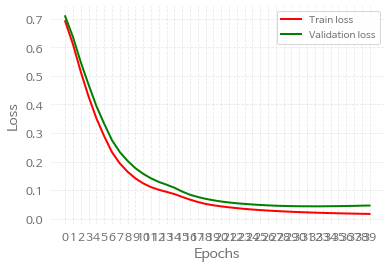

In [11]:
plt.figure()
plt.xticks(np.arange(0, len(train_loss), 1.0))
plt.ylabel("Loss")
plt.xlabel("Epochs")
train_line = plt.plot(range(0, len(train_loss)), train_loss, 'r', label="Train loss")
val_line = plt.plot(range(0, len(val_loss)), val_loss, 'g', label="Validation loss")
plt.legend()
plt.show()

Actual: green, predicted: red


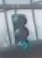

Actual: green, predicted: red


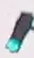

In [12]:
zipped_x_y = list(zip(test_x, test_y))
conf_true = []
conf_pred = []
for tt in range(0, len(zipped_x_y)):
  q = zipped_x_y[tt]
  sfmax = list(sess.run(tf.nn.softmax(y.eval(feed_dict={x: [q[0]]})))[0])
  sf_ind = sfmax.index(max(sfmax))

  predicted_label = image_types[sf_ind]
  actual_label = image_types[q[1].index(max(q[1]))]
  conf_true.append(actual_label)
  conf_pred.append(predicted_label)

  if predicted_label != actual_label:
    print("Actual: {}, predicted: {}".format(actual_label, predicted_label))
    img_path = test_z[tt]
    ex_img = Image(filename=img_path)
    display(ex_img) 

In [13]:
def plot_confusuion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes, rotation='vertical')
  plt.ylim(3, -2)
  cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  cm2 = np.around(cm2, 2)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, str(cm[i, j]) + "/" + str(cm2[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', rotation='vertical')
  plt.xlabel('Predicted label')

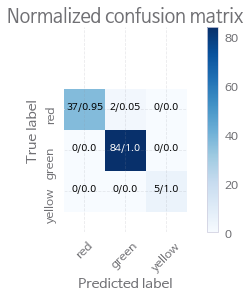

In [14]:
cnf_matrix = confusion_matrix(conf_true, conf_pred)
plt.figure()
plot_confusuion_matrix(cnf_matrix, classes=image_types, normalize=False, title='Normalized confusion matrix')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()